In [1]:
import numpy as np

import matplotlib.pyplot as plt
from plotnine import * 
import pandas as pd
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

# Step 1

In [2]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Empty"
        self.decay_time = 0
        self.lifetime = 0
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"
        if self.condition=="Burned Out":
            if self.decay_time == self.model.decay_time:
                self.condition="Empty"
            self.decay_time+=1
        if self.condition == "Fine" and self.lifetime == self.model.lifetime:
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Empty":
                    neighbor.condition="Fine"
                    neighbor.lifetime = 0
                    self.condition = "Empty"
        self.lifetime+=1

In [3]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density, decay_time, lifetime):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        self.decay_time = decay_time
        self.lifetime = lifetime
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out"),
                                "Empty": lambda m: self.count_type(m, "Empty")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                new_tree = TreeCell(self, (x, y))
                if self.random.random() < self.density:
                    # Create a tree
                    new_tree.condition = "Fine"
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.schedule.time > 200:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

In [4]:
fire = ForestFire(100, 100, 0.6, 10, 10)

In [5]:
fire.run_model()

In [6]:
results = fire.dc.get_model_vars_dataframe()
results

,Fine,On Fire,Burned Out,Empty
0,5830,74,129,0
1,5702,60,271,0
2,5589,53,391,0
3,5476,66,491,0
4,5370,52,611,0
...,...,...,...,...
196,2119,0,0,3914
197,2119,0,0,3914
198,2119,0,0,3914
199,2119,0,0,3914


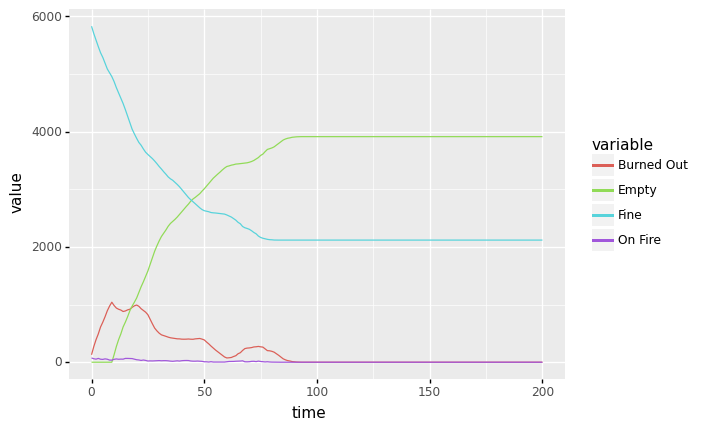

<ggplot: (-9223371914586013800)>

In [7]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Fine", "On Fire", "Burned Out", "Empty"])
ggplot(resultsmelt, aes(x="time", y="value", color="variable")) \
+ geom_line()

# Batch Runs

In [8]:
fixed_params = dict(height=50,width=50)
variable_params = dict(decay_time=np.linspace(0,60,2)[1:])

In [9]:
model_reporter = {"Fine": lambda m: (ForestFire.count_type(m, "Fine") / 
                                          m.schedule.get_agent_count()) }

In [10]:
param_run = BatchRunner(ForestFire, variable_parameters=variable_params, 
                        fixed_parameters=fixed_params, model_reporters=model_reporter)

In [11]:
param_run.run_all()

0it [00:00, ?it/s]


TypeError: __init__() missing 2 required positional arguments: 'density' and 'lifetime'